In [1]:
import pandas as pd
from ast import literal_eval
with open("005_results.jsonl", "r") as f:
    contents = f.readlines()
    contents = [literal_eval(i) for i in contents]

df = pd.DataFrame(data=contents)
df.tail(2)

,macroF1,y_true,y_pred,train_split,eval_split,model_name
250,0.798777,"[Neutral, Negative, Neutral, Neutral, Neutral,...","[Neutral, Neutral, Neutral, Negative, Neutral,...",train_SRB,test_HR,EMBEDDIA/crosloengual-bert
251,0.669872,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Negative, Neutral, Negative, Neutra...",train_SRB,test_SRB,EMBEDDIA/crosloengual-bert


In [2]:
import numpy as np

C_trained_on_train = df.train_split == "train"
C_evaled_on_test = df.eval_split == "test"
from typing import Iterable


def macroF1_stats(i: Iterable[float]) -> str:
    return f"{np.mean(i):0.4f} ± {np.std(i):0.4f}"


gb = df[C_trained_on_train & C_evaled_on_test].groupby(
    "model_name".split()
).agg(
    [macroF1_stats,
     #len
     ]
).rename(columns={"len": "sample size"}).sort_values(
    by=("macroF1", "macroF1_stats"), ascending=False
)
print(gb.to_latex())
gb

\begin{tabular}{ll}
\toprule
{} &          macroF1 \\
{} &    macroF1\_stats \\
model\_name                 &                  \\
\midrule
classla/bcms-bertic        &  0.7869 ± 0.0130 \\
EMBEDDIA/crosloengual-bert &  0.7720 ± 0.0111 \\
xlm-roberta-base           &  0.7224 ± 0.0194 \\
\bottomrule
\end{tabular}



,macroF1
,macroF1_stats
model_name,
classla/bcms-bertic,0.7869 ± 0.0130
EMBEDDIA/crosloengual-bert,0.7720 ± 0.0111
xlm-roberta-base,0.7224 ± 0.0194


## Is bertic better than cse bert?

In [3]:
from scipy.stats import mannwhitneyu

C_model_bertic = df.model_name == "classla/bcms-bertic"
C_model_csebert = df.model_name == "EMBEDDIA/crosloengual-bert"

bertic = df[C_trained_on_train & C_evaled_on_test & C_model_bertic].macroF1     
csebert = df[C_trained_on_train & C_evaled_on_test & C_model_csebert].macroF1   


mannwhitneyu(bertic, csebert, alternative="greater").pvalue


0.0021349439482391858

In [4]:
from pint import UnitRegistry
u = UnitRegistry()

<Figure size 288x288 with 0 Axes>

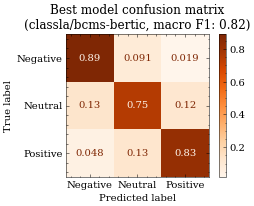

In [5]:
C_model_bertic = df.model_name == "classla/bcms-bertic"

subset = df[C_trained_on_train & C_evaled_on_test# & C_model_bertic
]
best_result = subset.iloc[subset.macroF1.argmax(), :]
y_true = best_result["y_true"]
y_pred = best_result["y_pred"]

import matplotlib.pyplot as plt
plt.style.use("science no-latex".split())
plt.figure(figsize=(4,4))
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred, cmap="Oranges", labels=["Negative", "Neutral", "Positive"],
   normalize="true"
   )

plt.title(f"Best model confusion matrix\n({best_result['model_name']}, macro F1: {best_result['macroF1']:0.2f})")
plt.savefig("images/006_best_cm_normalized_true.png")
plt.savefig("images/006_best_cm_normalized_true.pdf")

plt.show()

In [6]:
df.groupby(["model_name", "train_split", "eval_split"]).agg(
    [macroF1_stats, len]
)#.sort_values(by=("macroF1","macroF1_stats"), ascending=False)

macroF1      
                                                     macroF1_stats   len
model_name                 train_split eval_split                       
EMBEDDIA/crosloengual-bert train       test        0.7720 ± 0.0111  12.0
                                       test_HR     0.8107 ± 0.0116  12.0
                                       test_SRB    0.7102 ± 0.0176  12.0
                           train_HR    test_HR     0.7922 ± 0.0197  12.0
                                       test_SRB    0.6835 ± 0.0129  12.0
                           train_SRB   test_HR     0.7989 ± 0.0118  12.0
                                       test_SRB    0.6922 ± 0.0269  12.0
classla/bcms-bertic        train       test        0.7869 ± 0.0130  18.0
                                       test_HR     0.8153 ± 0.0130  18.0
                                       test_SRB    0.7449 ± 0.0216  18.0
                           train_HR    test_HR     0.8020 ± 0.0113  18.0
                                       test_SRB    0.7458 ± 0.0208  18.0
                           train_SRB   test_HR     0.8150 ± 0.0185  18.0
                                       test_SRB    0.7533 ± 0.0145  18.0
xlm-roberta-base           train       test        0.7224 ± 0.0194   6.0
                                       test_HR     0.7670 ± 0.0285   6.0
                                       test_SRB    0.6549 ± 0.0159   6.0
                           train_HR    test_HR     0.6608 ± 0.1974   6.0
                                       test_SRB    0.5804 ± 0.1600   6.0
                           train_SRB   test_HR     0.4869 ± 0.2294   6.0
                                       test_SRB    0.4231 ± 0.1656   6.0

# Inspecting individual models' performance on cross-parliament data

In [7]:
from IPython.display import display

for model_name in df.model_name.unique():
    print("Model:", model_name)
    C_model = df.model_name == model_name
    C_train_on_fulltrain = df.train_split == "train"
    C_test_on_full_test = df.eval_split == "test"
    gb = df[C_model & (~C_train_on_fulltrain) & (~ C_test_on_full_test)].groupby(["train_split", "eval_split"]).agg(
    macroF1_stats)
    display(gb)

Model: classla/bcms-bertic


macroF1
train_split eval_split                 
train_HR    test_HR     0.8020 ± 0.0113
            test_SRB    0.7458 ± 0.0208
train_SRB   test_HR     0.8150 ± 0.0185
            test_SRB    0.7533 ± 0.0145

Model: EMBEDDIA/crosloengual-bert


macroF1
train_split eval_split                 
train_HR    test_HR     0.7922 ± 0.0197
            test_SRB    0.6835 ± 0.0129
train_SRB   test_HR     0.7989 ± 0.0118
            test_SRB    0.6922 ± 0.0269

Model: xlm-roberta-base


macroF1
train_split eval_split                 
train_HR    test_HR     0.6608 ± 0.1974
            test_SRB    0.5804 ± 0.1600
train_SRB   test_HR     0.4869 ± 0.2294
            test_SRB    0.4231 ± 0.1656

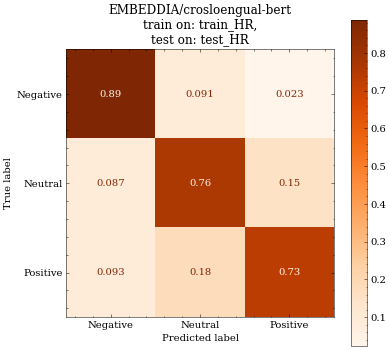

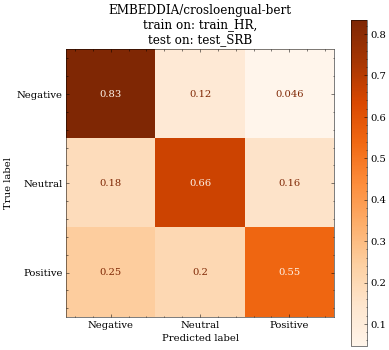

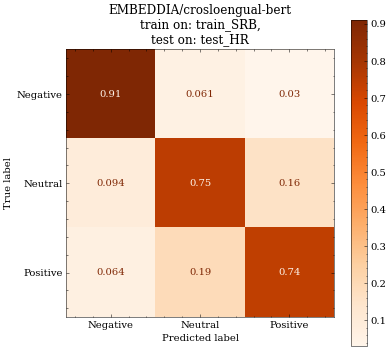

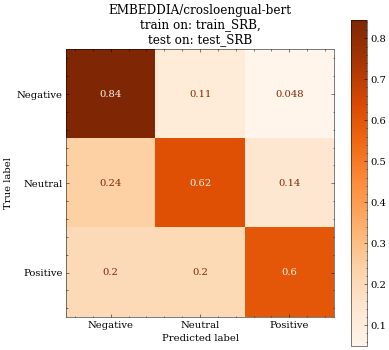

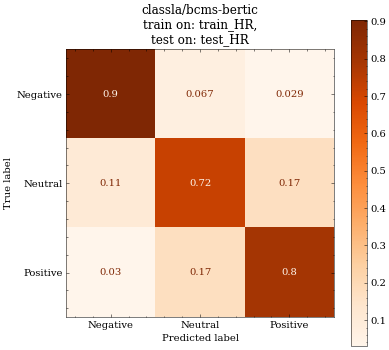

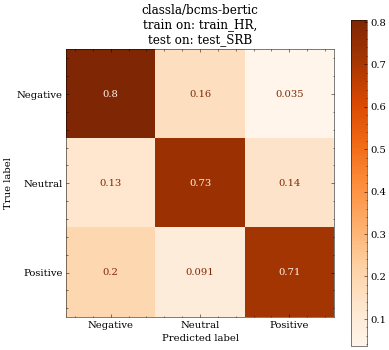

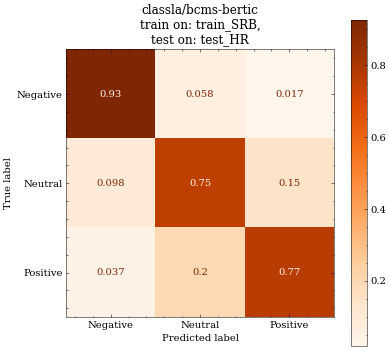

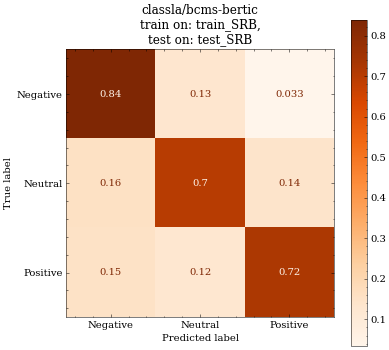

In [18]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])
from sklearn.metrics import ConfusionMatrixDisplay

for model in ["EMBEDDIA/crosloengual-bert", "classla/bcms-bertic"]:
    for train in ["train_HR", "train_SRB"]:
        for test in ["test_HR", "test_SRB"]:
            C_model = df.model_name==model
            C_train = df.train_split == train
            C_test = df.eval_split == test
            subset = df[C_model & C_train & C_test]
            y_true = []
            y_pred = []
            for i in subset.y_true.values:
                y_true.extend(i)
            for i in subset.y_pred.values:
                y_pred.extend(i)
            fig, ax = plt.subplots(figsize=(6,6))
            ConfusionMatrixDisplay.from_predictions(
            y_true, y_pred, cmap="Oranges", labels=["Negative", "Neutral", "Positive"],
            ax = ax,
            normalize="true"
            )
            plt.title(f"{model}\ntrain on: {train},\ntest on: {test}")
            plt.savefig(f"images/CMs/006_{model.replace('/', '_')}_{train=}_{test=}.png")
            plt.savefig(f"images/CMs/006_{model.replace('/', '_')}_{train=}_{test=}.pdf")
            plt.show()

In [12]:
subset

,macroF1,y_true,y_pred,train_split,eval_split,model_name
21,0.760555,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Negative, Neutral, Negative, Negati...",train_SRB,test_SRB,classla/bcms-bertic
25,0.745701,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Negative, Neutral, Negative, Negati...",train_SRB,test_SRB,classla/bcms-bertic
29,0.760809,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Negative, Neutral, Negative, Negati...",train_SRB,test_SRB,classla/bcms-bertic
33,0.776494,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Negative, Neutral, Negative, Negati...",train_SRB,test_SRB,classla/bcms-bertic
37,0.752063,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Negative, Neutral, Negative, Neutra...",train_SRB,test_SRB,classla/bcms-bertic
41,0.735968,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Negative, Neutral, Negative, Negati...",train_SRB,test_SRB,classla/bcms-bertic
63,0.735220,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Neutral, Neutral, Negative, Negativ...",train_SRB,test_SRB,classla/bcms-bertic
67,0.761458,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Negative, Neutral, Negative, Negati...",train_SRB,test_SRB,classla/bcms-bertic
71,0.767446,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Negative, Neutral, Negative, Negati...",train_SRB,test_SRB,classla/bcms-bertic
75,0.737005,"[Positive, Negative, Neutral, Negative, Negati...","[Negative, Neutral, Neutral, Negative, Negativ...",train_SRB,test_SRB,classla/bcms-bertic
